In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from timeit import default_timer as timer

1) Compute a disparity map for the images left.png and right.png (having parallel
optical axes) using the basic stereo matching algorithm. Use the NCC function to
perform the template matching for each patch in the left image searching in the right
image (search only leftward from – and including! – the starting point along each
row!), and use a window size of 11x11 pixels. To make things run a bit faster for the
grader, when searching leftward, only move up to 50 pixels to the left (instead of
going all the way to the edge of the image). Use the following Matlab code (or
Python equivalent) to display the disparity map D with a gray colormap and clip the
disparity values at 50 pixels, making sure to display the full range of remaining
values (e.g., using Matlab’s imagesc function): [5 pts]

In [2]:
left = imread('left.png')
right = imread('right.png')

In [3]:
def stereo_match(left_img, right_img, kernel=11, max_offset=50):
    start = timer()
    w, h = left_img.shape 
    depth = np.zeros((w, h), np.uint8)
    depth.shape = h, w
    kernel_half = kernel // 2 
    offset_adjust = 255 / max_offset
      
    for y in range(kernel_half, h - kernel_half):      
        
        for x in range(kernel_half, w - kernel_half):
            best_offset = 0
            prev_ncc = float("-inf")
            
            for offset in range(max_offset):   
                
                ncc = 0
                
                lwindow = left[y-kernel_half:y+kernel_half, x-kernel_half:x+kernel_half]
                rwindow = right[y-kernel_half:y+kernel_half, x-kernel_half:x+kernel_half]
                
                lwindow_mean = lwindow.mean()
                lwindow_std = np.std(lwindow)
                rwindow_mean = rwindow.mean()
                rwindow_std = np.std(rwindow)
                
                for v in range(-kernel_half, kernel_half):
                    for u in range(-kernel_half, kernel_half):
                        ncc_temp = (int(left[y+v, x+u]) - lwindow_mean) * (int(right[y+v, (x+u) - offset]) - rwindow_mean)
                        if lwindow_std ==0 or rwindow_std ==0:
                            ncc_temp = 0
                        else:
                            ncc_temp /= lwindow_std*rwindow_std
                        ncc += ncc_temp 
                    
                
                            
                if ncc > prev_ncc:
                    prev_ncc = ncc
                    best_offset = offset

            depth[y, x] = best_offset * offset_adjust
    end = timer()
    print("Time taken by this code: ", end - start)
    return depth


Time taken by this code:  233.3042930419324


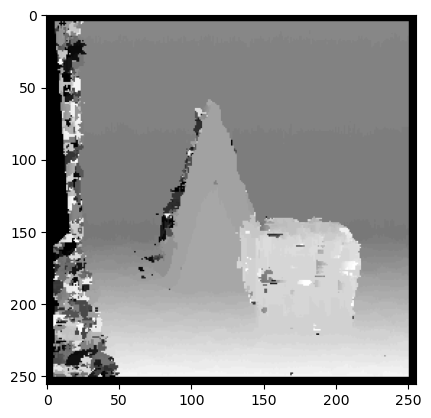

In [4]:
plt.imshow(stereo_match(left, right), cmap='gray')

**Discussion:**
The images given were fairly difficult for me (a human) to make out the depth, because of all the patterns. However, it seems like these weird patterns make it easier for a computer to detect depth, because there is a concrete uniform pattern to match in each image.

2) Use the points in file train.txt as training data (this file contains 1 row for each data
point where the first two columns are x,y coordinates and the third column is the
ground truth classification label – there are 2 classes). Classify all the test data points
in the file test.txt (formatted in the same way) using K=1. Calculate and report the
accuracy of your algorithm (compared to the third column ground truth of the test
data). Plot the test data points, color coded by the class label your algorithm gives
(use plot() options 'r.' and 'b.'). On the same figure (use hold on/off), (re)plot
the points which are misclassified (use plot() option 'ko' or something similar to
easily identify these points). Repeat this for K=5, 11, and 15. Compare the plots and
accuracy results for different values of K. [4 pts]

In [5]:
train = np.loadtxt('train.txt')
test = np.loadtxt('test.txt')
X_train, y_train = train[:,0:2], train[:,2]
X_test, y_test = test[:,0:2], test[:,2]

In [6]:
neighbours = [1, 5, 11, 15]

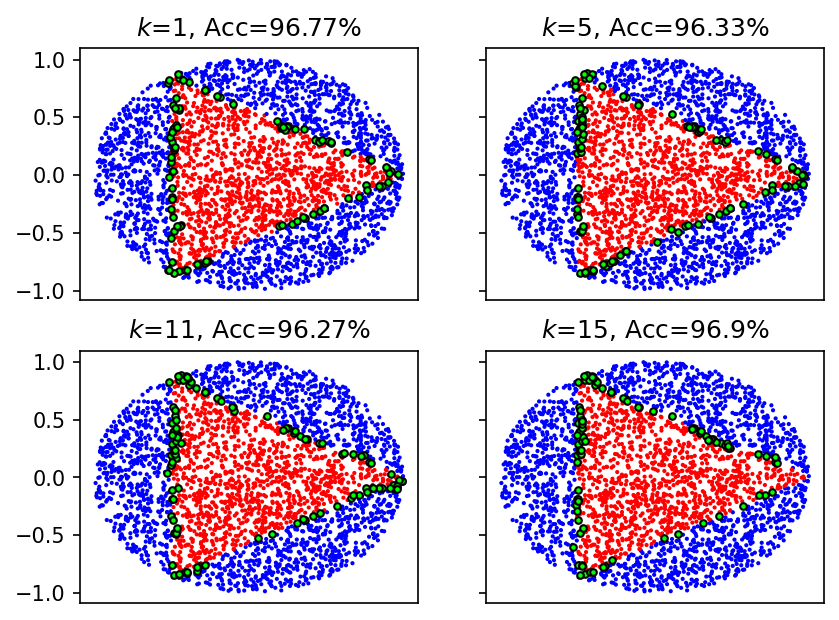

In [7]:
f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', dpi=150)
for n in neighbours:
    idx = neighbours.index(n)
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    axarr[idx//2,idx%2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axarr[idx//2,idx%2].scatter(X_test[:, 0], X_test[:, 1], c=y_pred, cmap=cmap_bold, s=1)
    axarr[idx//2,idx%2].scatter(X_test[y_pred!=y_test, 0], X_test[y_pred!=y_test, 1], c='#00FF00', edgecolor='k', cmap=cmap_bold, s=10)
    axarr[idx//2,idx%2].set_title(f"$k$={n}, Acc={round(model.score(X_test, y_test)*100, 2)}%")
plt.show()

**Discussion:**
We notice that most of the errors made in classification, it is at the border of our classes, this is expected as that is where the nearest neighbours will be the most contested. However as we increase our , at first we notice that our accuracy decreases, as in this case there might be cases where more neighbours cause the classifier to be misled. But once we reach =15, we see that our accuracy jumps up, thus indicating that at this stage we are getting sufficient enough information from our neighbours that its indicative of our overall sample.